In [1]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Lambda, LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import copy
from scipy.spatial.distance import cosine as cosine_distance
from keras.models import model_from_json
from collections import Counter
import import_ipynb
import drawingGraph as G
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Using TensorFlow backend.


importing Jupyter notebook from drawingGraph.ipynb


In [2]:
def getIndexFromGraph(filename):
    index = int(filename.split('-')[0].replace('graph', ''))
    return index

In [3]:
def calculateGraphGroup(num_dict):
    for index, data in enumerate(all_data):
        loc = getIndexFromGraph(graph_group[index])
        num_dict[loc] += 1
    return num_dict

In [4]:
def getEmbeddingSum():
    sum_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index, data in enumerate(all_data):
        data = data.reshape(1, data.shape[0], data.shape[1])
        embedded = encoder.predict(data)
        loc = getIndexFromGraph(graph_group[index])
        sum_embedding[loc] += embedded.reshape(embedded.shape[1])
    return sum_embedding

In [5]:
def getEmbeddingAvg():
    avg_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    sum_embedding = getEmbeddingSum()
    for index in range(graph_length):
        avg_embedding[index] = sum_embedding[index] / num_dict[index]
    return avg_embedding

In [6]:
def getEmbeddingVector(index):
    data_index = []
    data = []
    counts = num_dict[index]
    for num, i in enumerate(graph_group):
        if index == getIndexFromGraph(i):
            data_index.append(num)
        if len(data_index) == counts:
            break
    for i in data_index:
        dt = all_data[i].reshape(1, all_data[i].shape[0], all_data[i].shape[1])
        dt = encoder.predict(dt)
        dt = dt.reshape(dt.shape[1])
        data.append(dt)
    return data

In [7]:
def getMode(values):
    values.sort()
    mode = Counter(values).most_common()
    maximum = mode[0][1]
    if maximum == 1:
        return values.mean()
    else:
        dt = []
        for m in mode:
            if maximum == m[1]:
                dt.append(m[0])
            else:
                break
        return np.array(dt).mean()

In [8]:
def getEmbeddingMode(): # 최빈값
    mode_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            mode_embedding[index][count] = getMode(values)
        mode_embedding[index] = np.array(mode_embedding[index])
    return mode_embedding

In [9]:
def getEmbeddingExceptMinMax():
    except_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            values.sort()
            except_embedding[index][count] =  values[1:-1].mean()
        except_embedding[index] = np.array(except_embedding[index])
    return except_embedding

In [10]:
def euclidean_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum(a-b) ** 2)

In [11]:
def getGraphOrder(dist):
    ordered = copy.deepcopy(dist)
    ordered.sort()
    
    names = []
    
    for item in ordered:
        for index, d in enumerate(dist):
            if item == d:
                names.append(index)#+1)
                break
    return names, ordered

In [12]:
def getDistFromEmbedding(distance_measure, embedding, obj):
    if embedding  == 'sum':
        embeddings = sum_embedding
    elif embedding == 'avg':
        embeddings = avg_embedding
    elif embedding == 'mode':
        embeddings = mode_embedding
    elif embedding =='except':
        embeddings = except_embedding
    
    dist = []
    for embed in embeddings:
        if distance_measure == 'euc':
            dist.append(euclidean_distance(obj, embed))
        else:
            dist.append(cosine_distance(obj, embed))
    return dist

In [13]:
def getTopData(n, datasets, names):
    data = []
    for n in names[:n+1]:
        data.append(datasets[n])
    return data

In [14]:
def draw(drawobj, drawobj_name, dir_name, save):
    for index, obj in enumerate(drawobj):
        G.drawGraph(dir_name, 'graph' + str(drawobj_name[index]), index, obj, save)

In [15]:
filename = input('filename: ')
json_file = open("mse_cce_models/latest_lstmae_cce.json", "r") #"+filename+"
loaded_model_json = json_file.read() 
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('mse_cce_models/'+ filename + '.h5')

filename: weights_latest_lstmae_cce


W1007 22:57:40.779649 139727696901888 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 22:57:40.810851 139727696901888 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1007 22:57:40.814258 139727696901888 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1007 22:57:41.339581 139727696901888 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [16]:
sequence_type = input('type(bfs? dfs?): ')
if sequence_type == 'dfs':
    dir = './latest_sequence/dfs/*'
else:
    dir = './latest_sequence/bfs/*'

# file read
all_data = []
sequence_length = []
graph_group = []
for file in sorted(glob.glob(dir)):
    graph_group.append(file.split('/')[-1].replace('.txt', ''))
    datasets = []
    for f in open(file, 'r'):
        (u, v, w) = f[1:-2].split(',')
        datasets.append([int(u), int(v), float(w)])
    sequence_length.append(len(datasets))
    all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

type(bfs? dfs?): 


In [17]:
graph_length = len(glob.glob('./latest_graph_data/*'))
embedded_length = 64

In [18]:
lstm_autoencoder = loaded_model

In [19]:
encoder = Model(lstm_autoencoder.input, lstm_autoencoder.layers[2].output)

In [20]:
num_dict = { i:0 for i in range(graph_length)}
num_dict = calculateGraphGroup(num_dict)

In [21]:
sum_embedding = getEmbeddingSum()
avg_embedding = getEmbeddingAvg()
mode_embedding = getEmbeddingMode()
except_embedding = getEmbeddingExceptMinMax()

In [22]:
except_embedding = np.array(except_embedding)

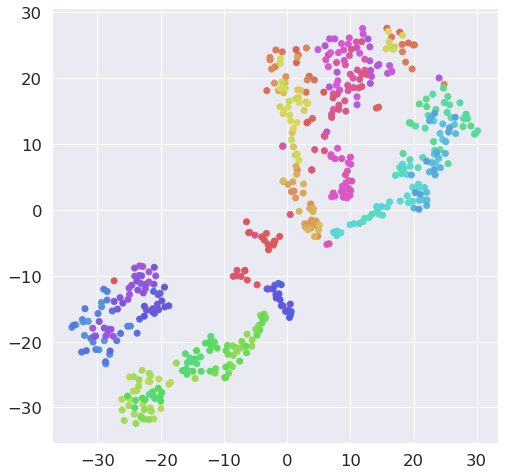

In [45]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
labels = [str(i) for i in range(528)]
tsne_train_xs = TSNE(random_state=42).fit_transform(except_embedding)
plt.figure(figsize=(8, 8))
plt.scatter(x = tsne_train_xs[:,0], y=tsne_train_xs[:,1], color=sns.color_palette("hls", 527))
plt.show()

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 527 samples in 0.001s...
[t-SNE] Computed neighbors for 527 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 527 / 527
[t-SNE] Mean sigma: 0.191585
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.038620
[t-SNE] KL divergence after 1000 iterations: 0.538265


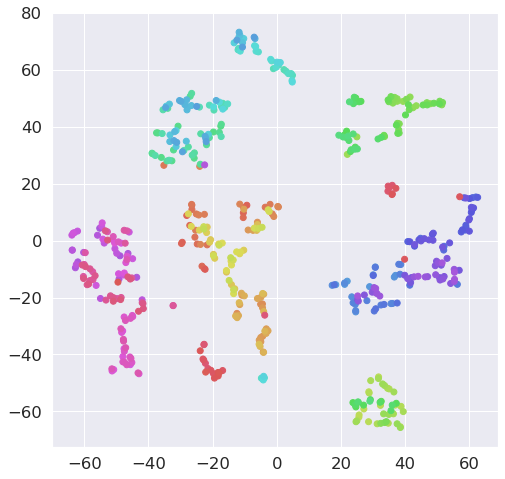

In [59]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
labels = [str(i) for i in range(528)]
tsne_train_xs = TSNE(n_components=2, verbose=1, perplexity=6, n_iter=1000).fit_transform(except_embedding)
plt.figure(figsize=(8, 8))
plt.scatter(x = tsne_train_xs[:,0], y=tsne_train_xs[:,1], color=sns.color_palette("hls", 527))
plt.show()

In [350]:
#그래프 그리기 위해 각 그래프 그룹 가운데 하나씩 가져옴. (모든 노드에 대한 sequence 에서 하나의 노드 시퀀스만 가져오기) 
datasets = [[] for i in range(graph_length)]
for n, data in zip(graph_group, all_data):
    index = int(n.split('-')[0].replace('graph', ''))
    if len(datasets[index]) == 0:
        d = []
        for row in data:
            u, v, w = row
            d.append([int(u), int(v), float(w)])
        datasets[index] = d

In [382]:
mode_obj = mode_embedding[456]
sum_obj = sum_embedding[456]
avg_obj = avg_embedding[456]
except_obj = except_embedding[456]

In [383]:
dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)

dist_sum_cos = getDistFromEmbedding('cos', 'sum', sum_obj)
names_sum_cos, ordered_sum_cos = getGraphOrder(dist_sum_cos)

dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)

dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)

In [384]:
dist_avg_euc = getDistFromEmbedding('euc', 'avg', avg_obj)
names_avg_euc, ordered_avg_euc = getGraphOrder(dist_avg_euc)

dist_sum_euc = getDistFromEmbedding('euc', 'sum', sum_obj)
names_sum_euc, ordered_sum_euc = getGraphOrder(dist_sum_euc)

dist_mode_euc = getDistFromEmbedding('euc', 'mode', mode_obj)
names_mode_euc, ordered_mode_euc = getGraphOrder(dist_mode_euc)

dist_except_euc = getDistFromEmbedding('euc', 'except', except_obj)
names_except_euc, ordered_except_euc = getGraphOrder(dist_except_euc)

In [385]:
top10_mode_cos = getTopData(10, datasets, names_mode_cos)
back10_mode_cos = getTopData(10, datasets, names_mode_cos[::-1])

top10_sum_cos = getTopData(10, datasets, names_sum_cos)
back10_sum_cos = getTopData(10, datasets, names_sum_cos[::-1])

top10_avg_cos = getTopData(10, datasets, names_avg_cos)
back10_avg_cos = getTopData(10, datasets, names_avg_cos[::-1])

top10_except_cos = getTopData(10, datasets, names_except_cos)
back10_except_cos = getTopData(10, datasets, names_except_cos[::-1])

In [386]:
top10_mode_euc = getTopData(10, datasets, names_mode_euc)
back10_mode_euc = getTopData(10, datasets, names_mode_euc[::-1])

top10_sum_euc = getTopData(10, datasets, names_sum_euc)
back10_sum_euc = getTopData(10, datasets, names_sum_euc[::-1])

top10_avg_euc = getTopData(10, datasets, names_avg_euc)
back10_avg_euc = getTopData(10, datasets, names_avg_euc[::-1])

top10_except_euc = getTopData(10, datasets, names_except_euc)
back10_except_euc = getTopData(10, datasets, names_except_euc[::-1])

In [387]:
# check top n results
count = 0
print('    {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
#for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print('{:8d}{:8d}{:8d}{:8d}'.format(s, a, m, e))
    count += 1
    if count >= 21:
        break
count = 0
print('    {:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
#for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print('{:8d}{:8d}{:8d}{:8d}'.format(s, a, m, e))
    count += 1
    if count > 21:
        break
        

    sum     avg     mode    except(min, max)
     456     456     456     456
     444     444     451     451
     451     451     444     444
     433     433     433     433
     462     462     462     459
     459     459     459     462
     464     464     440     464
     440     440     447     440
     447     447     464     447
     445     445     445     445
     499     499     499     499
     441     441     498     441
     498     498     441     498
     495     495     495     460
     431     431     460     481
     460     460     481     495
     448     448      73     424
      73      73     434      73
     461     461     494     434
     424     424     487     431
     434     434     467     448
    sum     avg     mode    except(min, max)
     526     526     514     526
     504     504     526     519
     502     502     504     504
     520     520     502     520
     519     519     519     502
     512     512     520     514
     514     514   

cos mode


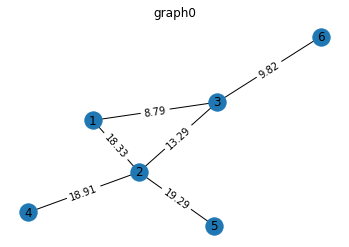

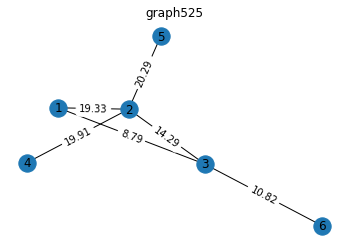

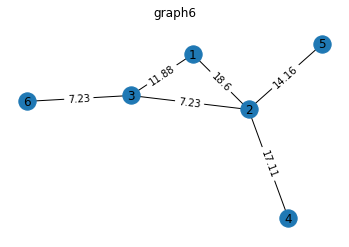

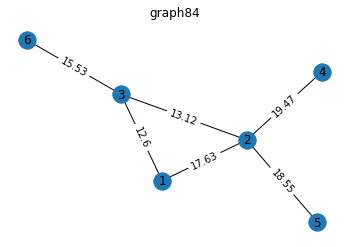

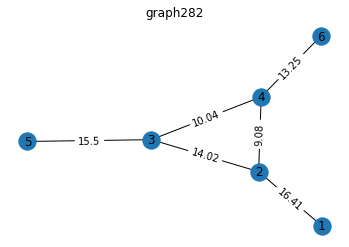

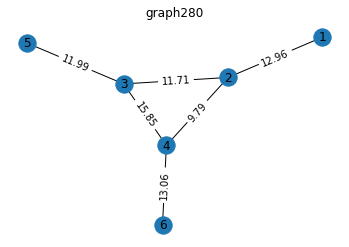

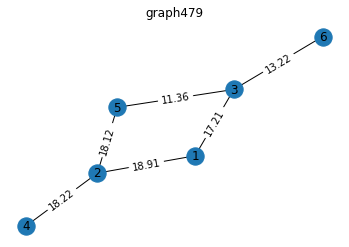

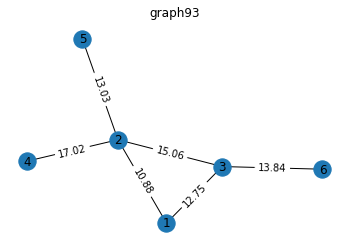

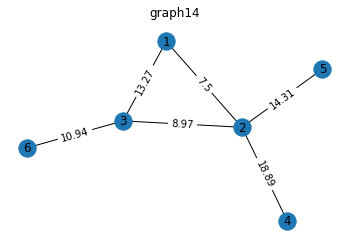

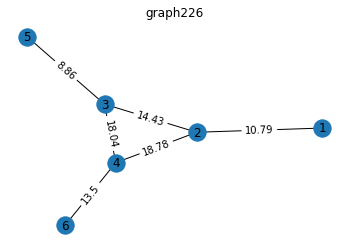

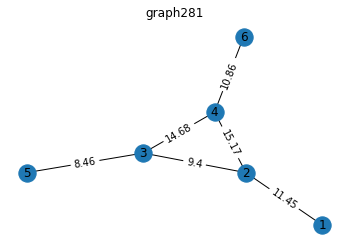

In [357]:
print("cos mode")
draw(top10_mode_cos, names_mode_cos, '', False)

cos except min max


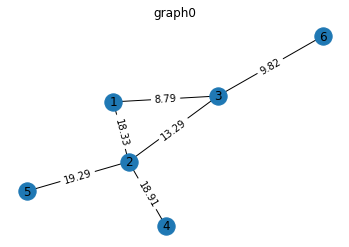

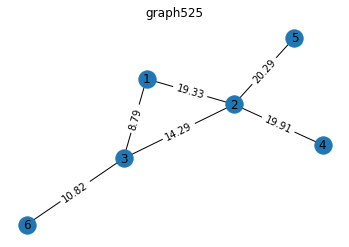

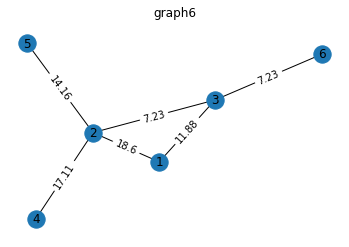

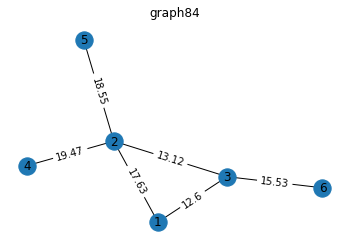

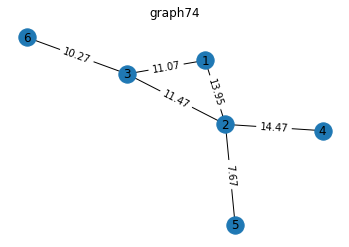

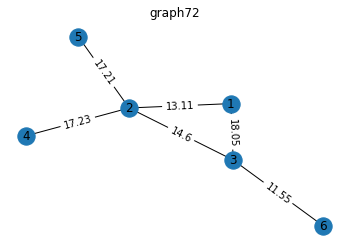

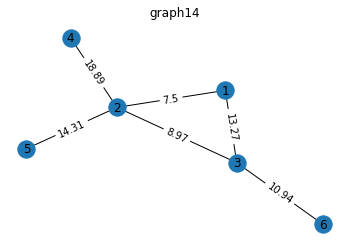

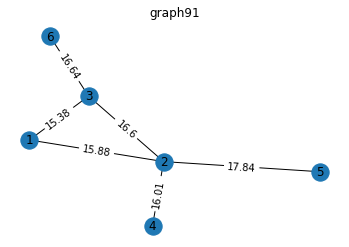

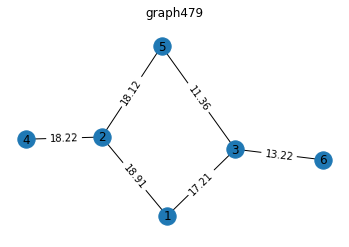

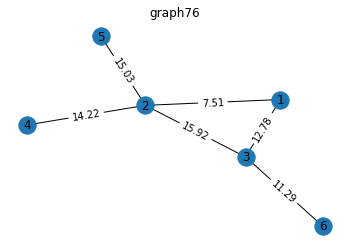

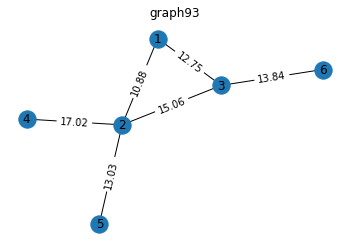

In [358]:
print("cos except min max")
draw(top10_except_cos, names_except_cos, '', False)

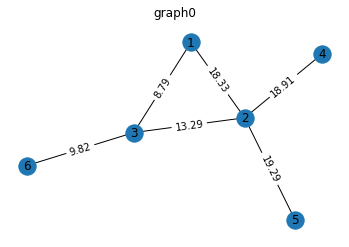

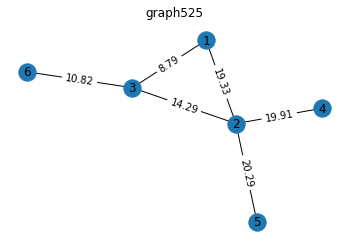

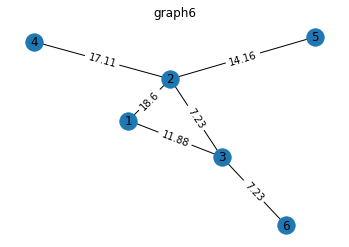

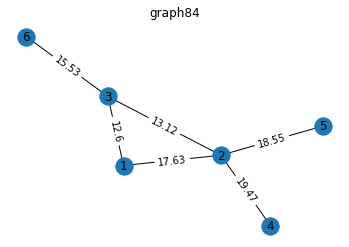

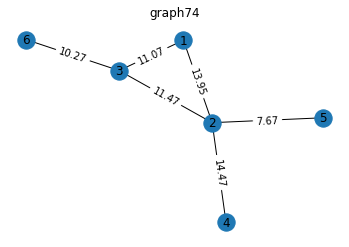

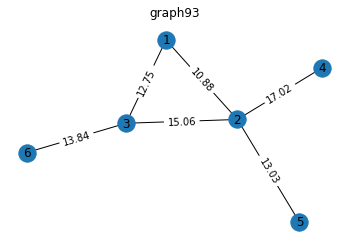

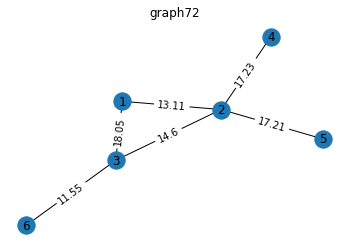

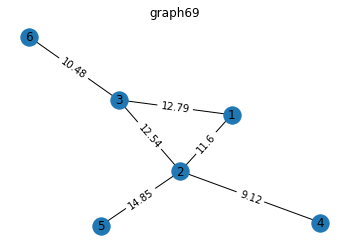

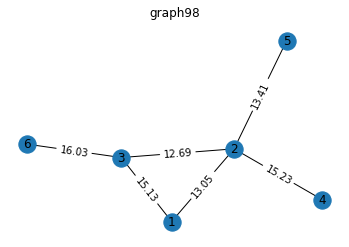

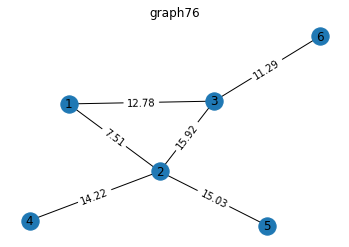

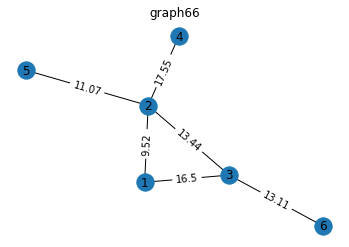

In [30]:
draw(top10_sum_cos, names_sum_cos, '', False)

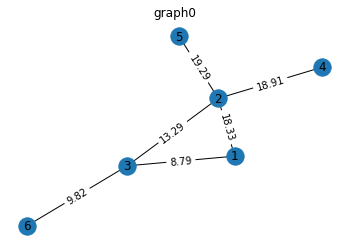

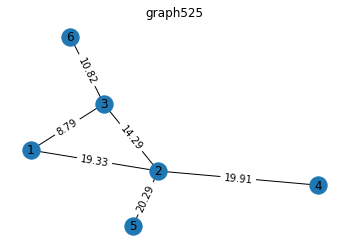

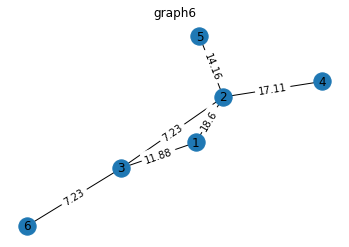

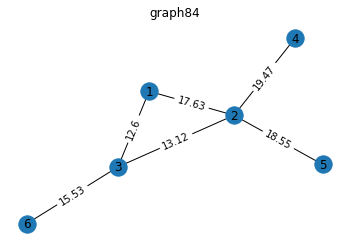

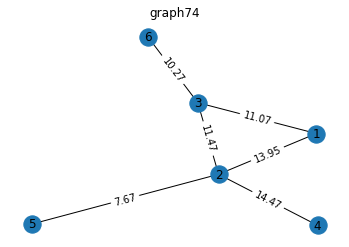

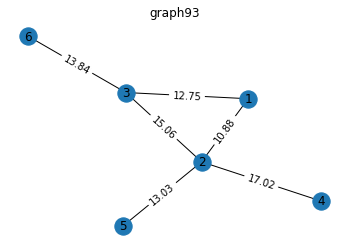

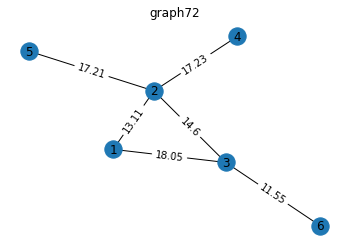

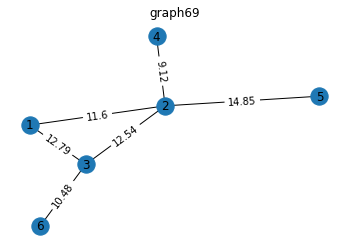

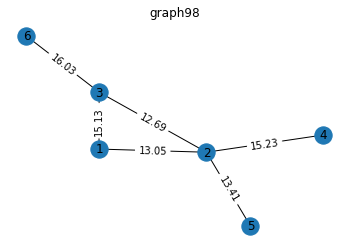

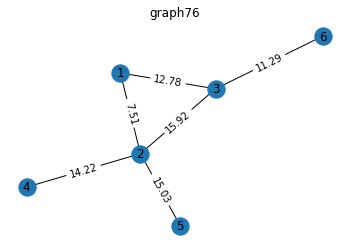

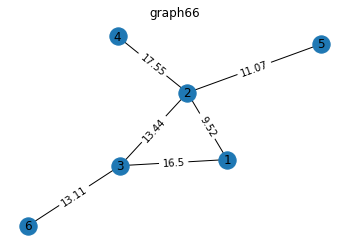

In [31]:
draw(top10_avg_cos, names_avg_cos, '', False)

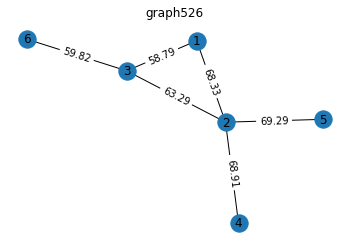

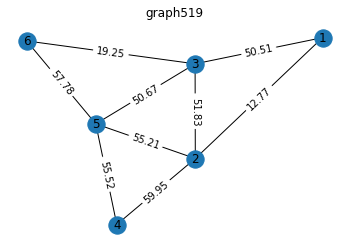

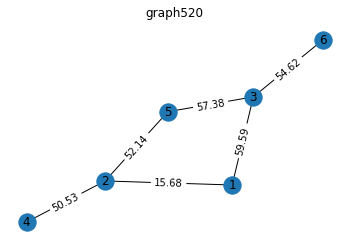

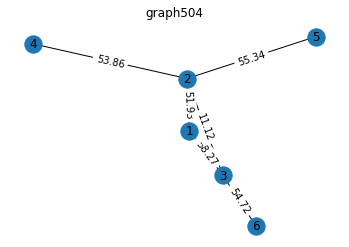

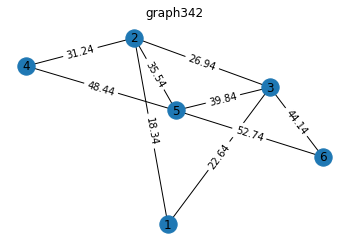

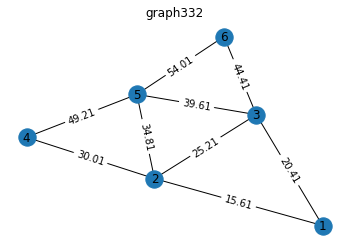

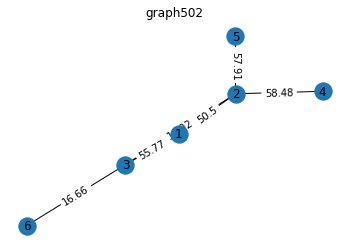

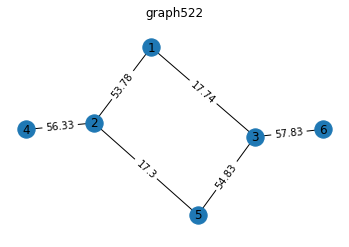

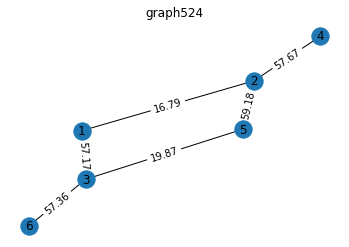

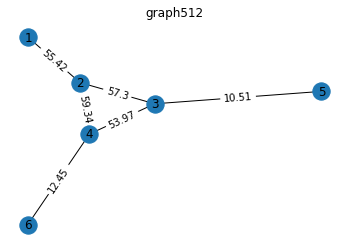

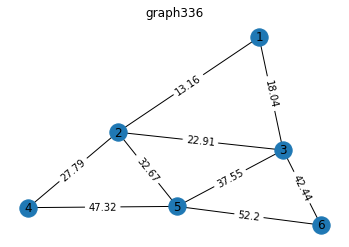

In [32]:
draw(back10_except_cos, names_except_cos[::-1], '', False)

In [359]:
mode_embedding[0]

array([ 0.        ,  0.788749  ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.2456209 ,
        0.        ,  0.        ,  0.7615942 , -0.94061047,  0.        ,
        0.47650146,  0.33913612,  0.        ,  0.        ,  0.6051499 ,
        0.19923472, -0.40439215,  0.        , -0.5131677 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.62069887,  0.27759078,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.06250497,  0.        ,  0.5833512 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.10939953, -0.4285115 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.40322423], dtype=float32)

In [360]:
mode_embedding[525]

array([ 0.        ,  0.7775984 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.219894  ,
        0.        ,  0.        ,  0.7615942 , -0.94569546,  0.        ,
        0.43205914,  0.3172762 ,  0.        ,  0.        ,  0.5800938 ,
        0.20706184, -0.36763588,  0.        , -0.50852627,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.599659  ,  0.24952084,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.05278549,  0.        ,  0.56483793,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.4177471 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.41906527], dtype=float32)

In [361]:
mode_embedding[526]

array([ 0.        ,  0.        ,  0.        , -0.07151384, -0.49343622,
        0.        ,  0.        ,  0.        ,  0.7615942 ,  0.        ,
        0.        ,  0.        ,  0.07282892,  0.        ,  0.        ,
        0.        ,  0.        , -0.10908339,  0.        , -0.691365  ,
        0.        ,  0.        ,  0.        ,  0.33542848, -0.70962507,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.640617  ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.75524235,  0.        ,  0.        ,  0.13901041,  0.        ,
        0.        ,  0.        ,  0.        , -0.5137544 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.84168977, -0.74156076], dtype=float32)

In [362]:
cosine_distance(mode_embedding[0], mode_embedding[525])

0.0019312500953674316

In [363]:
cosine_distance(mode_embedding[0], mode_embedding[526])

1.1197287440299988